<a href="https://colab.research.google.com/github/Taejin1221/MachineLearning/blob/master/TrajectoryAugmentation/Augmentation_U_net(3x3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import cv2, os, glob, random
import numpy as np
import pandas as pd

# Util Functions

In [ ]:
import random, cv2
import numpy as np
import pandas as pd


# 빈 캔버스 만들기
def init() -> np.array: 
    blank = np.zeros([512,512],dtype=np.uint8)
    blank.fill(0)
    blank = cv2.resize(blank,(512,512))

    return blank

# Convert 0-1 Images into 0-255 Image
def drawNp( img: np.array, dotForm ) -> np.array:
    '''
    dotForm = 0 : 1x1 dot
    dotForm = 1 : crosshead (3x3)
    dotForm = 2 : 3x3 dot
    '''
    blank = init()

    rowDiff = [ [ 0 ], [ -1, 0, 0, 0, 1 ], [ -1, -1, -1, 0, 0, 0, 1, 1, 1 ] ]
    colDiff = [ [ 0 ], [ 0, -1, 0, 1, 0 ], [ -1, 0, 1, -1, 0, 1, -1, 0, 1 ] ]

    for i in range( 0, img.shape[0] ):
        for j in range( 0, img.shape[1] ):
            if img[i][j] == 1 :
                for rr, cc in zip( rowDiff[dotForm], colDiff[dotForm] ):
                    newRow, newCol = i + rr, j + cc
                    if ( 0 <= newRow < img.shape[0] and 0 <= newCol < img.shape[1] ):
                        blank[newRow][newCol] = 255

    return blank


# Convert csv File to Image
def map2Image(min_max: tuple, dot: int, csv_file: pd.DataFrame) -> np.array:
    inputImage = np.zeros([512,512], dtype=np.uint8)

    minX, minY, maxX, maxY = min_max

    for i in range(0,csv_file.shape[0]):
        x = csv_file.loc[i][0]
        y = csv_file.loc[i][1]

        # Print Dot
        mapX = int(round(np.interp(x,[minX,maxX],[0,500])))
        mapY = int(round(np.interp(y,[minY,maxY],[0,500])))
        inputImage[mapX][mapY] = 1

    outputImage = drawNp(inputImage, dot)

    rotImage = np.rot90(outputImage)

    return rotImage


# Convert csv File to Image with Noise
def map2Image_noise(min_max: tuple, dot: int, csv_file: pd.DataFrame) -> np.array:
    inputImage = np.zeros([512,512], dtype=np.uint8)

    minX, minY, maxX, maxY = min_max

    randomList = set()
    while len(randomList) < int(csv_file.shape[0] / 7):
        randomList.add(random.randint(0,csv_file.shape[0]))

    randomList=list(randomList)
    dicisionList = [1,-1]

    for i in range(0, csv_file.shape[0]):
        try:
            # Generate Noise
            randomList.index(i)

            r = random.uniform((minX - maxX) / 40,(minX - maxX) / 20)
            D = random.choice(dicisionList)

            x = csv_file.loc[i][0] - (D * r)
            y = csv_file.loc[i][1] - (D * r)

            # Paint dot
            mapX = int(round(np.interp(x,[minX,maxX],[0,500])))
            mapY = int(round(np.interp(y,[minY,maxY], [0,500])))
            inputImage[mapX][mapY] = 1

        except:
            x = csv_file.loc[i][0]
            y = csv_file.loc[i][1]

            mapX = int(round(np.interp(x,[minX,maxX],[0,500])))
            mapY = int(round(np.interp(y,[minY,maxY], [0,500])))
            inputImage[mapX][mapY] = 1


    outputImage = drawNp(inputImage, dot)

    rotImage = np.rot90(outputImage)

    return rotImage


def map2Image_remove(min_max: tuple, dot: int, csv_file: pd.DataFrame) -> np.array:
    inputImage = np.zeros([512,512], dtype=np.uint8)

    minX, minY, maxX, maxY = min_max

    removeList = [ ]
    fileNum = csv_file.shape[0]
    for _ in range( int( fileNum * 0.5 ) ):
        idx = random.randint( 0, fileNum )
        while ( idx in removeList ):
            idx = random.randint( 0, fileNum )

        removeList.append( idx )

    for i in range(0, fileNum):
        if ( i in removeList ):
            continue

        x = csv_file.loc[i][0]
        y = csv_file.loc[i][1]

        # Print Dot
        mapX = int(round(np.interp(x,[minX,maxX],[0,500])))
        mapY = int(round(np.interp(y,[minY,maxY],[0,500])))
        inputImage[mapX][mapY] = 1

    outputImage = drawNp(inputImage, dot)

    rotImage = np.rot90(outputImage)

    return rotImage


# Return Max and Min X,Y Coordinate Value of file
def coorMaxMin(file: pd.DataFrame) -> (float, float, float, float):
    minX, minY = (file.loc[0][0], file.loc[0][1])
    maxX, maxY = (file.loc[0][0], file.loc[0][1])
    for i in range(0,file.shape[0]):
        x = file.loc[i][0]
        y = file.loc[i][1]
        if x > maxX :
            maxX = x
        if x < minX :
            minX = x
        if y > maxY :
            maxY = y
        if y < minY :
            minY = y
    return minX, minY, maxX, maxY


# Loading Data and Conveting into Image

In [ ]:
# dataDir = "/content/drive/My Drive/Data/VirtualData"

In [ ]:
SIZE = 512

# os.chdir( dataDir )
files = glob.glob( '*csv' )

trainSize = int( len( files ) * 0.8 )
trainFiles, testFiles = files[ : trainSize], files[trainSize : ]

In [ ]:
print( len( files ) )

66


In [ ]:
X_train, Y_train = [ ], [ ]
for file in trainFiles:
	csv_file = pd.read_csv( file, names = [ 'lat', 'long', 'num' ], header = None )
	maxmin = coorMaxMin( csv_file )
	X_train.append( map2Image_remove( maxmin, 2, csv_file ) )
	Y_train.append( map2Image( maxmin, 2, csv_file ) )

X_test = [ ]
for file in testFiles:
	csv_file = pd.read_csv( file, names = [ 'lat', 'long', 'num' ], header = None )
	maxmin = coorMaxMin( csv_file )
	X_test.append( map2Image_remove( maxmin, 2, csv_file ) )

In [ ]:
print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))

(52, 512, 512)
(52, 512, 512)
(14, 512, 512)


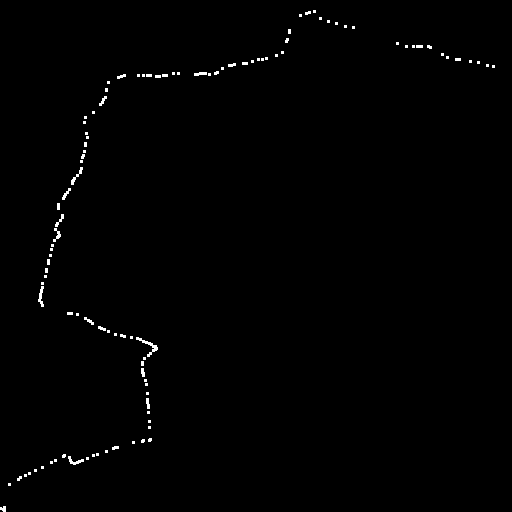

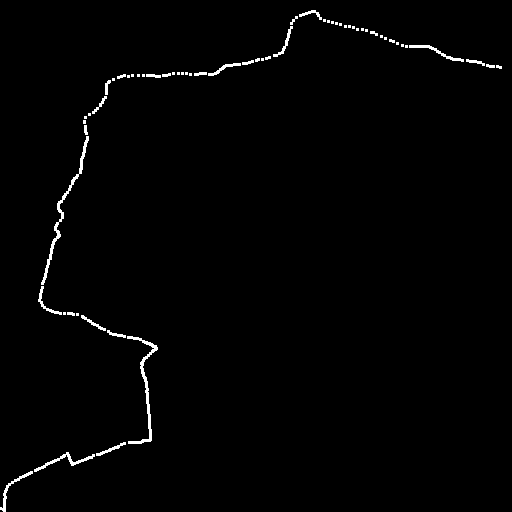

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow( X_train[0] )
cv2_imshow( Y_train[0] )

## Resize Images for CNN

In [ ]:
## Resize Images for CNN ##
X_train, Y_train = np.array( X_train ), np.array( Y_train )
X_test = np.array( X_test )

X_train = X_train.astype( 'float32' ) / 255.
Y_train = Y_train.astype( 'float32' ) / 255.
X_test = X_test.astype( 'float32' ) / 255.

print( X_train.shape, Y_train.shape, X_test.shape )

X_train = np.reshape( X_train, ( len( X_train ), SIZE, SIZE, 1 ) )
Y_train = np.reshape( Y_train, ( len( Y_train ), SIZE, SIZE, 1 ) )
X_test = np.reshape( X_test, ( len( X_test ), SIZE, SIZE, 1 ) )

print( 'train shape (X, Y): ({},{})'.format( X_train.shape, Y_train.shape ) )
print( 'test shape (X): ({})'.format( X_test.shape ) )

(52, 512, 512) (52, 512, 512) (14, 512, 512)
train shape (X, Y): ((52, 512, 512, 1),(52, 512, 512, 1))
test shape (X): ((14, 512, 512, 1))


# Constructing Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
 ## Hyper Parameter ##
acti, pad = 'relu', 'same'

## Input Image ##
input_img = layers.Input(shape=(512, 512, 1))

# Encoding #
conv1 = layers.Conv2D( 64, ( 3, 3 ), activation = 'relu', padding = 'same' )( input_img )
pool1 = layers.MaxPooling2D( ( 2, 2 ), padding = 'same' )( conv1 )

conv2 = layers.Conv2D( 32, ( 3, 3 ),  activation = 'relu', padding = 'same' )( pool1 )
pool2 = layers.MaxPooling2D( ( 2, 2 ), padding = 'same' )( conv2 )

conv3 = layers.Conv2D( 16, ( 3, 3 ), activation = 'relu', padding = 'same' )( pool2 )
pool3 = layers.MaxPooling2D( ( 2, 2 ), padding = 'same' )( conv3 )


# Decoding #
conv4 = layers.Conv2D( 16, ( 3, 3 ), activation = 'relu', padding = 'same' )( pool3 )
up1 = layers.UpSampling2D( ( 2, 2 ) )( conv4 )

merge1 = layers.concatenate([conv3,up1])
conv5 = layers.Conv2D( 32, ( 3, 3 ), activation = 'relu', padding = 'same' )( merge1 )
up2 = layers.UpSampling2D( ( 2, 2 ) )( conv5 )

#merge2 = concatenate([conv2,up2])
conv6 = layers.Conv2D( 64, ( 3, 3 ), activation = 'relu', padding = 'same' )( up2 )
up3 = layers.UpSampling2D( ( 2, 2 ) )( conv6 )


decoded = layers.Conv2D( 1, ( 3, 3 ), activation = 'sigmoid', padding = 'same' )( up3 )

## Compile Model

In [ ]:
## Compile
Unet = keras.Model(input_img, decoded)
Unet.summary()

Unet.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'acc' ] )


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 18464       max_pooling2d[0][0]              
______________________________________________________________________________________________

## Train Model

In [ ]:
EPOCH = 30
BATCH = 10
SHUFFLE = True

history = Unet.fit( X_train, Y_train, epochs = EPOCH, batch_size = BATCH, shuffle = SHUFFLE )

Epoch 1/30
6/6 [==============================] - 5s 348ms/step - loss: 0.6750 - acc: 0.9777
Epoch 2/30
6/6 [==============================] - 1s 224ms/step - loss: 0.3967 - acc: 0.9930
Epoch 3/30
6/6 [==============================] - 1s 225ms/step - loss: 0.1697 - acc: 0.9926
Epoch 4/30
6/6 [==============================] - 1s 221ms/step - loss: 0.0938 - acc: 0.9928
Epoch 5/30
6/6 [==============================] - 1s 223ms/step - loss: 0.0668 - acc: 0.9925
Epoch 6/30
6/6 [==============================] - 1s 222ms/step - loss: 0.0362 - acc: 0.9933
Epoch 7/30
6/6 [==============================] - 1s 223ms/step - loss: 0.0303 - acc: 0.9925
Epoch 8/30
6/6 [==============================] - 1s 223ms/step - loss: 0.0250 - acc: 0.9926
Epoch 9/30
6/6 [==============================] - 1s 222ms/step - loss: 0.0236 - acc: 0.9925
Epoch 10/30
6/6 [==============================] - 1s 223ms/step - loss: 0.0224 - acc: 0.9928
Epoch 11/30
6/6 [==============================] - 1s 221ms/step - lo

In [ ]:
decoded_img = Unet.predict( X_test  )

In [ ]:
print(np.shape(decoded_img))

(14, 512, 512, 1)


# Test Model

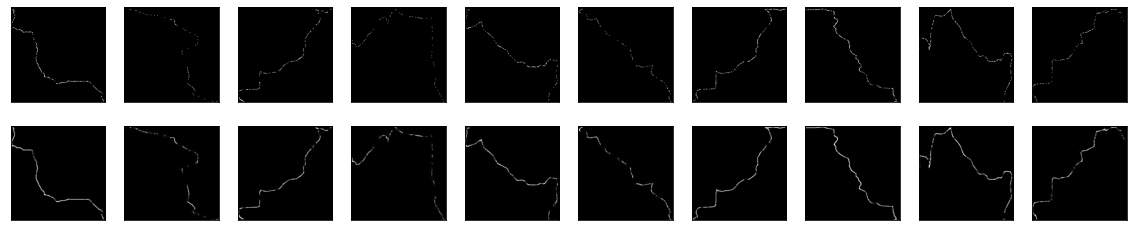

In [ ]:
import matplotlib.pyplot as plt

n = 10
plt.figure( figsize = ( 20, 4 ) )
for i in range( n ):
	ax = plt.subplot( 2, n, i + 1 )
	plt.imshow( X_test[i].reshape( SIZE, SIZE) )
	plt.gray()

	ax.get_xaxis().set_visible( False )
	ax.get_yaxis().set_visible( False )

	ax = plt.subplot( 2, n, n + i + 1 )
	plt.imshow( decoded_img[i].reshape( SIZE, SIZE))
	plt.gray()

	ax.get_xaxis().set_visible( False )
	ax.get_yaxis().set_visible( False )

plt.savefig( 'Result.png', dpi = 300 )
plt.show()